In [9]:
import pandas as pd
import string
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from scipy.sparse import hstack
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from xgboost import XGBClassifier

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
data = pd.read_csv("dataset.csv")

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def advanced_preprocess(text):
    text = text.translate(str.maketrans("", "", string.punctuation)).lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

data["source_text"] = data["source_text"].apply(advanced_preprocess)
data["plagiarized_text"] = data["plagiarized_text"].apply(advanced_preprocess)

In [12]:
tfidf = TfidfVectorizer()
source_tfidf = tfidf.fit_transform(data["source_text"])
plag_tfidf = tfidf.transform(data["plagiarized_text"])

cos_sim = [cosine_similarity(s, p)[0][0] for s, p in zip(source_tfidf, plag_tfidf)]
cos_sim = np.array(cos_sim).reshape(-1, 1)

# Extra features: text lengths
source_len = data["source_text"].apply(lambda x: len(x.split())).values.reshape(-1, 1)
plag_len = data["plagiarized_text"].apply(lambda x: len(x.split())).values.reshape(-1, 1)

X = hstack([source_tfidf, plag_tfidf, cos_sim, source_len, plag_len])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid,
                                   n_iter=10, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\kanaa\OneDrive\Desktop\ML_final_project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:42:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Accuracy: 0.7972972972972973
ROC AUC: 0.9029304029304029

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.89      0.81        35
           1       0.88      0.72      0.79        39

    accuracy                           0.80        74
   macro avg       0.81      0.80      0.80        74
weighted avg       0.81      0.80      0.80        74



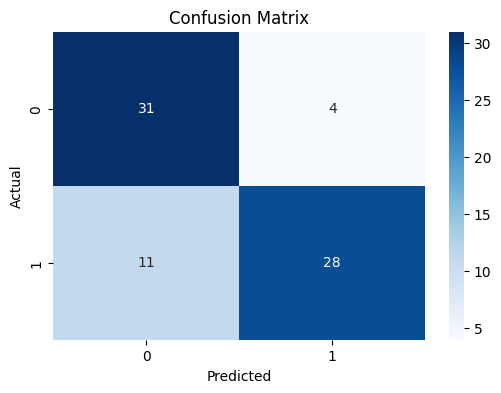

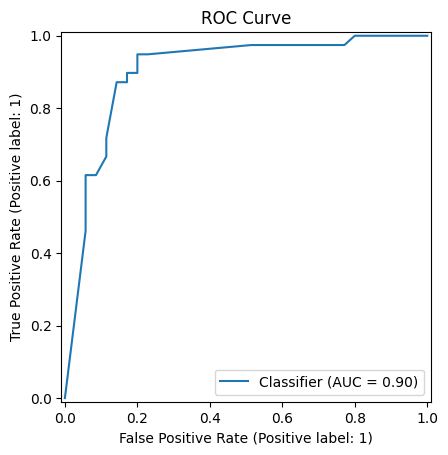

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

In [16]:
joblib.dump(best_model, "xgb_tuned_model.pkl")
joblib.dump(tfidf, "xgb_tfidf_vectorizer.pkl")
print("Model and vectorizer saved.")

Model and vectorizer saved.
